In [1]:
import numpy as np
import matplotlib.pyplot as plt

R  = 8.314
T  = 298.15
B  = 1/(R*T)
ph = np.arange(-14,14,0.1)

# reference pKa
ref_res={
    "D":3.90,
    "E":4.36,
    "C":8.55,
    "AA":4,
    "BB":3,
    "CC":8}

# for finding where dG_protein = 0
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


# for getting pka from ddG and reference
def getpKa(ddG,res,a=1):
    return ref_res[res] + a*ddG/(R*T*np.log(10))


# for getting dG_protein from ddG (i.e., subtract off peptide protonation)
def deltaG(ddG, res, T=T, ph=np.arange(-14,14,0.01),a=1.0):
    return ddG + a*(R*T*np.log(10)*(ref_res[res]-ph))


def coupled_ddG(ddG0, ddG1, ddG2, res, ph=np.arange(-14,14,0.01),a=1.0):    
    dG1 = deltaG(ddG1, res, T, ph, a)
    dG2 = deltaG(ddG2, res, T, ph, a)    
    
    return (ddG0 +\
            (1/B)*np.log(1+np.exp(-B*dG1)) -\
            (1/B)*np.log(1+np.exp(-B*dG2)))

# for resolving protonation probabilities as a function of dG
def partition(dG1,dG2,dG3,ph=np.arange(-14,14,0.01)):
    
    B = 1/(R*T)
    mu = (B**(-1))*np.log(10)*ph
    
    Z = 1 + np.exp(-B*(dG1-mu))+\
            np.exp(-B*(dG2-mu))+\
            np.exp(-B*((dG1+dG3)-2*mu))
    
    return 1/Z, np.exp(-B*(dG1-mu))/Z, np.exp(-B*(dG2-mu))/Z, np.exp(-B*((dG1+dG3)-2*mu))/Z


# relating microscopic and macroscopic pKa values
def macro(pk1,pk2,w):
    pka1 = pk1
    pka2 = pk2
    w    = w
        
    Ka1 = np.exp(-pka1)
    Ka2 = np.exp(-pka2)
    
    Ka1a = np.exp(-(pka1-w))
    Ka2a = np.exp(-(pka2-w))
    
    
    return -np.log((Ka1*Ka2)/(Ka1+Ka2)), -np.log(Ka1a+Ka2a)


In [2]:
#  Toy example 4
#
#     (F11)   -18     (F01)
#   CH + BH  -->  C- + BH
#
#  8  |               | 28
#     V               V
#             2
#   CH + B-  -->  C- + B-
#    (F10)         (F00)

res1="C"
res2="E"

ddG1 =   -18 * 1000
ddG2 =    8 * 1000
ddG3 =   28 * 1000
ddG4 =    2 * 1000

plain
pKa1: 8.90, pKa2: 9.27

adjust
pKa1: 5.60, pKa2: 9.00


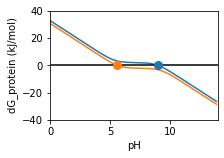

In [3]:
fig, axs = plt.subplots(1,1,figsize=(3,2))

# compute apparent ddG(pH) due to forward and backwards
# add peptide deprot to get dG_protein
# (i.e., ddG = dGprotein - dG_peptide -> ddG + dG_peptide = dG_protein)
dG_protein1 = coupled_ddG(ddG1,ddG2,ddG3,res2,ph=ph,a=1.0) + R*T*np.log(10)*(ref_res[res1]-ph) 
dG_protein2 = coupled_ddG(ddG2,ddG1,ddG4,res1,ph=ph,a=1.0) + R*T*np.log(10)*(ref_res[res2]-ph)

plt.plot(ph,dG_protein1/1000,color='tab:orange')
plt.plot(ph,dG_protein2/1000,color='tab:blue')

# find when dG_protein = 0
idx1 = find_nearest(dG_protein1,0)
idx2 = find_nearest(dG_protein2,0)

# get corresponding pH, which will be the pKa
pka1 = ph[idx1]
pka2 = ph[idx2]

axs.plot(pka1,0,'o',ms=8,zorder=10,color='tab:orange')
axs.plot(pka2,0,'o',ms=8,zorder=10,color='tab:blue')

axs.axhline(0,color='k')
axs.set_xlim(0,14)
axs.set_ylim(-40,40)
axs.set_xlabel("pH")
axs.set_ylabel("dG_protein (kJ/mol)")

print("plain\npKa1: %.2f, pKa2: %.2f\n" % (getpKa(ddG4,res=res1),
                                  getpKa(ddG3,res=res2)))

print("adjust\npKa1: %.2f, pKa2: %.2f" % (ph[idx1],
                                  ph[idx2]))

(0.0, 14.0)

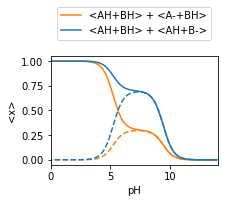

In [4]:
fig, axs = plt.subplots(1,1,figsize=(3,2))

# get standard deprotonation free energy (i.e.dG_protein(pH=0))
dG1 = deltaG(ddG1,res1,ph=0)
dG2 = deltaG(ddG2,res2,ph=0)
dG3 = deltaG(ddG3,res2,ph=0)
dG4 = deltaG(ddG4,res1,ph=0)

# utilize Hill formalism to get microstates
a,b,c,d = partition(dG1,dG2,dG3,ph=ph)

plt.plot(ph,a+c,color='tab:orange',label="<AH+BH> + <A-+BH>")
plt.plot(ph,c,color='tab:orange',ls='dashed')

plt.plot(ph,a+b,color='tab:blue',label="<AH+BH> + <AH+B->")
plt.plot(ph,b,color='tab:blue',ls='dashed')

plt.ylabel("<x>")
plt.xlabel("pH")
plt.legend(loc='upper center',bbox_to_anchor=(0.5,1.5))
plt.xlim(0,14)